# Woody vegitation classifier using random forrest model - that needs to be trained

### What does this notebook do?
This notebook creates and trains a SKlearn model from a saved CSV file to classify woody vegitation in a Sentinel 2 geogedian. 
This notebook takes a NetCDF as input to classify and outputs a NetCDF with a band called 'class' added which is a boolian layer showing the classification for woody vegitation

### Requierments 


It requieres the input Geodiam to be saved as a NetCDF file with the following band in the following order: 'blue', 'green','red', 'rededge1', 'rededge2', 'rededge3', 'nir1', 'nir2', 'swir1', 'swir2'. for best results use a Geomedian generated using NBART.

You need to run the following commands from the command line prior to launching jupyter notebook from the same terminal so that the required libraries and paths are set.

    $ module use /g/data/v10/public/modules/modulefiles

    $ module load dea


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
#load moduels
#load modules
import datacube
from datacube.storage import masking
from datacube import Datacube
from datetime import datetime
from skimage import exposure
from datacube import helpers

import gdal

import rasterio
from datacube_stats.statistics import GeoMedian
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

import geopandas as gpd
from sklearn.ensemble import ExtraTreesClassifier
import datacube_stats
import os
# Replace '156' and 'ck9738' with the path to your own home directory on the VDI
s2aws = Datacube(config='/g/data/u46/users/ck9738/datacube-s2ard.conf')

In [4]:
#define filepath to Geomedian NetCDF input and output

gm_to_open = '/g/data/u46/users/ck9738/SENT_GEOMEDIAN/sixteenth_tiles_3577_15_-38/35_15_-138.8.nc'

output_file = '/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/classification_outputs/gm_treeclass_15_-38_mini8_ausalps11.nc'

#define the file location of the training dataset 

training_file = '/g/data/u46/users/ck9738/Datasets/ML_for_smad_green/Glueviz_datasets/aus_alps_traning_11_small_even.csv'

In [6]:

#load geomedian into a xr dataset
Geomedian_dataset = xr.open_dataset(gm_to_open, drop_variables=("crs",'dataset','albers_conical_equal_area'))

Geomedian_dataset

<xarray.Dataset>
Dimensions:  (x: 2500, y: 2500)
Coordinates:
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * y        (y) float64 -3.775e+06 -3.775e+06 -3.775e+06 -3.775e+06 ...
Data variables:
    Band1    (y, x) float32 ...
    Band2    (y, x) float32 ...
    Band3    (y, x) float32 ...
    Band4    (y, x) float32 ...
    Band5    (y, x) float32 ...
    Band6    (y, x) float32 ...
    Band7    (y, x) float32 ...
    Band8    (y, x) float32 ...
    Band9    (y, x) float32 ...
    Band10   (y, x) float32 ...
Attributes:
    GDAL_AREA_OR_POINT:  Area
    Conventions:         CF-1.5
    GDAL:                GDAL 2.2.4, released 2018/03/19
    history:             Tue Sep 25 15:07:12 2018: GDAL CreateCopy( 35_15_-13...

In [7]:
#transform the dataset into the format needed to feed to the machine learning algorithm, a 'flat' array with shape [(x,y),bands]
#we combine axies x and y into one new dimention called z

Geomedian_flat = Geomedian_dataset.stack(z=('x','y'))
Geomedian_flat = (Geomedian_flat.to_array().astype(np.float)).squeeze()
Geomedian_flat = Geomedian_flat.transpose()

Geomedian_flat = Geomedian_flat.fillna(0)

In [8]:
Geomedian_flat

<xarray.DataArray (z: 6250000, variable: 10)>
array([[ 683.,  972., 1370., ..., 2568., 3170., 2312.],
       [ 675.,  984., 1396., ..., 2576., 3184., 2323.],
       [ 664.,  972., 1382., ..., 2578., 3241., 2376.],
       ...,
       [ 232.,  349.,  407., ..., 1904., 1508.,  866.],
       [ 222.,  330.,  356., ..., 1724., 1312.,  736.],
       [ 209.,  314.,  320., ..., 1722., 1317.,  739.]])
Coordinates:
  * z         (z) MultiIndex
  - x         (z) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  - y         (z) float64 -3.775e+06 -3.775e+06 -3.775e+06 -3.775e+06 ...
  * variable  (variable) <U6 'Band1' 'Band2' 'Band3' 'Band4' 'Band5' 'Band6' ...

In [9]:
np.all(np.isfinite(Geomedian_flat))

True

In [10]:
#load traning data from file 

training_data = pd.read_csv(training_file)
training_data

,Unnamed: 0,Band 1,Band 2,Band 3,Band 4,Band 5,Band 6,Band 7,Band 8,Band 9,Band 10,class
0,1398133,499.0,729.0,938.0,1288.0,1903.0,2107.0,2245.0,2435.0,2893.0,1875.0,0
1,2410916,792.0,1097.0,1541.0,1810.0,2081.0,2245.0,2405.0,2556.0,3603.0,2890.0,0
2,301376,239.0,344.0,354.0,632.0,1218.0,1398.0,1480.0,1607.0,1316.0,769.0,1
3,1175305,289.0,406.0,464.0,807.0,1495.0,1713.0,1829.0,1970.0,1741.0,1017.0,1
4,2604143,656.0,934.0,1207.0,1603.0,2251.0,2491.0,2618.0,2866.0,3216.0,2164.0,0
5,2586784,679.0,920.0,1149.0,1348.0,1932.0,2243.0,2541.0,2516.0,2810.0,2040.0,0
6,225113,341.0,493.0,612.0,867.0,1497.0,1713.0,1764.0,1962.0,1800.0,1147.0,1
7,2413110,491.0,687.0,765.0,1188.0,2110.0,2382.0,2633.0,2780.0,2412.0,1423.0,0
8,2473371,507.0,774.0,884.0,1335.0,2529.0,2915.0,3349.0,3331.0,2506.0,1517.0,0
9,825781,346.0,478.0,541.0,846.0,1632.0,1888.0,2026.0,2163.0,1738.0,1034.0,1


In [11]:

#remove any infinate or Nan samples
training_data = training_data.replace([np.inf, -np.inf], np.nan)
training_data = training_data.dropna(axis=0)
training_data

,Unnamed: 0,Band 1,Band 2,Band 3,Band 4,Band 5,Band 6,Band 7,Band 8,Band 9,Band 10,class
0,1398133,499.0,729.0,938.0,1288.0,1903.0,2107.0,2245.0,2435.0,2893.0,1875.0,0
1,2410916,792.0,1097.0,1541.0,1810.0,2081.0,2245.0,2405.0,2556.0,3603.0,2890.0,0
2,301376,239.0,344.0,354.0,632.0,1218.0,1398.0,1480.0,1607.0,1316.0,769.0,1
3,1175305,289.0,406.0,464.0,807.0,1495.0,1713.0,1829.0,1970.0,1741.0,1017.0,1
4,2604143,656.0,934.0,1207.0,1603.0,2251.0,2491.0,2618.0,2866.0,3216.0,2164.0,0
5,2586784,679.0,920.0,1149.0,1348.0,1932.0,2243.0,2541.0,2516.0,2810.0,2040.0,0
6,225113,341.0,493.0,612.0,867.0,1497.0,1713.0,1764.0,1962.0,1800.0,1147.0,1
7,2413110,491.0,687.0,765.0,1188.0,2110.0,2382.0,2633.0,2780.0,2412.0,1423.0,0
8,2473371,507.0,774.0,884.0,1335.0,2529.0,2915.0,3349.0,3331.0,2506.0,1517.0,0
9,825781,346.0,478.0,541.0,846.0,1632.0,1888.0,2026.0,2163.0,1738.0,1034.0,1


In [12]:
#split the training data into two arrays: an array for the features and an array for the classifications. this is what we
#will directly use to train the classifier

training_features = training_data.as_matrix(columns=['Band 1', 'Band 2','Band 3', 'Band 4', 'Band 5', 'Band 6', 
                                                     'Band 7', 'Band 8', 'Band 9', 'Band 10']).astype(np.float) #create Array of features for training
training_class = training_data.as_matrix(columns=['class']).astype(np.float) #create Array of classification answer for training
training_class

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:5: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  """
/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:6: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  


array([[0.],
       [0.],
       [1.],
       ...,
       [1.],
       [0.],
       [1.]])

In [13]:
# check that the training data contains no Nans. Pandas datafram will not give an error if you miss-index when transforming
#into a matrix, it will just give you an empty colum of the correct size instead
np.all(np.isfinite(training_features))

True

In [14]:
#define machine learning algarithm 
classifier_model = ExtraTreesClassifier(n_estimators=250, bootstrap=True, oob_score=True, random_state=0)
#250 estimators takes longer than default (10) but does a better job.
#n_jobs makes trees run in parralell, uses more memory but increases speed. 

classifier_model.fit(training_features,training_class)#fit the moddle to the training data
#train

/g/data/v10/public/modules/dea-env/20180728/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


ExtraTreesClassifier(bootstrap=True, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=250, n_jobs=1,
           oob_score=True, random_state=0, verbose=0, warm_start=False)

In [15]:
importance = classifier_model.feature_importances_
print(importance)

[0.08951307 0.14209955 0.10910367 0.10523174 0.09718306 0.05894466
 0.06171247 0.07948122 0.13511055 0.12162001]


In [16]:
#classify input data using trained classifier
results=classifier_model.predict(Geomedian_flat)

In [17]:
#if you change the size of the input Geomedian remeber to change the dimentions you are reshaping results to

#reshape results and turn into an XR array with appropreate dimentions/data type to re-join the GM dataset. 
results_back = results.reshape(2500,2500)
results_xr = xr.DataArray(results_back,dims=('x', 'y'),name='results')
results_xr = results_xr.astype('float32')
results_xr = results_xr.transpose()

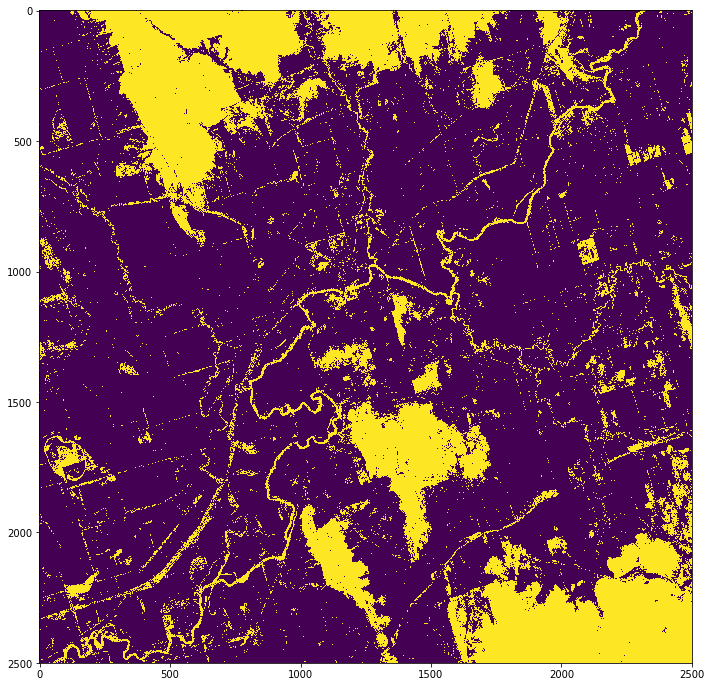

In [18]:
#view your awsone classification output
fig, ax = plt.subplots(figsize = (12,12))
cax = ax.imshow(results_xr)

plt.show()

In [19]:
#add classification results to dataset
##replace with Geomediam 
Geomedian_dataset["class"] = results_xr
#Geomedian_dataset["no_data"] = xr.DataArray(invalid_mask, dims=('x','y'), name='no_data')
Geomedian_dataset
#add smad/green to dataset?

<xarray.Dataset>
Dimensions:  (x: 2500, y: 2500)
Coordinates:
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * y        (y) float64 -3.775e+06 -3.775e+06 -3.775e+06 -3.775e+06 ...
Data variables:
    Band1    (y, x) float32 683.0 672.0 687.0 672.0 678.0 676.0 661.0 673.0 ...
    Band2    (y, x) float32 972.0 974.0 982.0 975.0 976.0 965.0 954.0 963.0 ...
    Band3    (y, x) float32 1370.0 1362.0 1369.0 1355.0 1355.0 1347.0 1328.0 ...
    Band4    (y, x) float32 1714.0 1713.0 1698.0 1697.0 1688.0 1692.0 1708.0 ...
    Band5    (y, x) float32 2099.0 2103.0 2078.0 2076.0 2059.0 2058.0 2088.0 ...
    Band6    (y, x) float32 2267.0 2273.0 2256.0 2255.0 2237.0 2235.0 2264.0 ...
    Band7    (y, x) float32 2431.0 2430.0 2433.0 2422.0 2402.0 2413.0 2437.0 ...
    Band8    (y, x) float32 2568.0 2575.0 2551.0 2549.0 2535.0 2532.0 2571.0 ...
    Band9    (y, x) float32 3170.0 3166.0 3171.0 3172.0 3160.0 3172.0 3165.0 ...
    Band10   (y, x) float32 2312.0 2308.0 230

<xarray.Dataset>
Dimensions:  (x: 2500, y: 2500)
Coordinates:
  * x        (x) float64 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 1.5e+06 ...
  * y        (y) float64 -3.775e+06 -3.775e+06 -3.775e+06 -3.775e+06 ...
Data variables:
    Band1    (y, x) float32 683.0 672.0 687.0 672.0 678.0 676.0 661.0 673.0 ...
    Band2    (y, x) float32 972.0 974.0 982.0 975.0 976.0 965.0 954.0 963.0 ...
    Band3    (y, x) float32 1370.0 1362.0 1369.0 1355.0 1355.0 1347.0 1328.0 ...
    Band4    (y, x) float32 1714.0 1713.0 1698.0 1697.0 1688.0 1692.0 1708.0 ...
    Band5    (y, x) float32 2099.0 2103.0 2078.0 2076.0 2059.0 2058.0 2088.0 ...
    Band6    (y, x) float32 2267.0 2273.0 2256.0 2255.0 2237.0 2235.0 2264.0 ...
    Band7    (y, x) float32 2431.0 2430.0 2433.0 2422.0 2402.0 2413.0 2437.0 ...
    Band8    (y, x) float32 2568.0 2575.0 2551.0 2549.0 2535.0 2532.0 2571.0 ...
    Band9    (y, x) float32 3170.0 3166.0 3171.0 3172.0 3160.0 3172.0 3165.0 ...
    Band10   (y, x) float32 2312.0 2308.0 230

In [21]:
Geomedian_dataset.to_netcdf(output_file,'w','NETCDF4')